# Bagging

* Consider the *regression problem*. 
* Suppose we fit a model to our training data $Z = \{(x_1, y_1), (x_2, y_2), . . . , (x_N , y_N )\}$, obtaining the prediction $\hat{f}(x)$ at input $x$

* Bootstrap aggregation or bagging averages this prediction over a collection of bootstrap samples, thereby reducing its variance

* For each bootstrap sample $Z^{∗b}, b = 1, 2, . . . , B$, we fit our model, giving prediction $\hat{f}^{∗b}$

$$ {f_{\text{bag}}}(x) = \frac{1}{B} \sum_{b = 1}^{B} \hat{f^{*b}}(x)$$


Denote by $\hat{P}$ the empirical distribution putting equal probability $1/N$ on each of the data points $(x_i, y_i)$

In fact the `true` bagging estimate is defined by $E_P[\hat{f}^{∗}(x)]$, where $Z^∗ = {(x^{∗}_1, y^{∗}_1), (x^{∗}_2, y^{∗}_2), . . . , (x^{∗}_N , y^{∗}_N )}$ and each $(x_i^{*} , y_i^{∗}) ∼ \hat{P}$. 

Expression is a Monte Carlo estimate of the true bagging estimate, approaching it as $B → ∞$

For Regression tree where $\hat{f}(x)$ denotes the tree’s prediction at input vector $x$ 

The bagged estimate is the average prediction at $x$ from these $B$ trees

In [2]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
import  numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import model_selection

In [303]:
# Data Simulation
x = np.random.randn(1_000, 1)
f = 9*np.sin(x)
e = 3*np.random.randn(1_000)
y = f.flatten() + e

# split data
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    x, y, random_state=123, test_size=0.25)
# fitting a model tree for each bag

In [304]:
# np.random.choice(x_train, size=10, replace=True)
indices = np.indices((x_train.shape[0],))
indices = indices.flatten()

In [305]:
bagging_indices = np.random.choice(indices, size=x_train.shape[0], replace=True)

In [346]:
trees_predicts = []
b = 20
while b >=1:
    bagging_indices = np.random.choice(indices, size=x_train.shape[0], replace=True)
    x_bagging = x_train[bagging_indices, :]
    y_bagging = y_train[bagging_indices]
    tree = DecisionTreeRegressor() 
    tree.fit(x_bagging, y_bagging)
    # Predicts using the tree model
    x_predict_bagging = tree.predict(x_test)
    # reshape in order to concatenate for data test
    trees_predicts.append(np.reshape(x_predict_bagging,  (-1, 1)))
    b-=1
    
# compute the mean of the prediction
trees_predicts_df=pd.DataFrame(np.hstack(trees_predicts))
predict_bagging = np.hstack(trees_predicts).mean(axis=1)

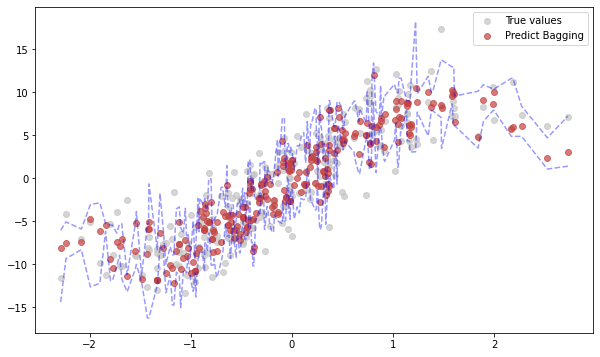

In [386]:
fig, ax= plt.subplots(figsize = (10, 6))

labels = ['True values', 'Predict Bagging']
colors = [(197/255, 196/255, 196/255), (197/255, 67/255, 67/255)]
variables = [y_test, predict_bagging]

for label, color, variable in zip(labels, colors, variables):
    ax.scatter(x_test.flatten(), variable, alpha = 0.7, label = label, color=color)

# --> Plot the maximun and minimun 
# 1. Get Max an Min of the predicts (quantile(0) is the minimun and quantile(1) is the maximun)
quantiles = trees_predicts_df.quantile([0,  1], axis=1).T
# 2. The outcome values is passed like index
quantiles.index = x_test.flatten()
# 3. Sort the by index, that is (by outcome values)
quantiles.sort_index(axis=0, ascending=True, inplace=True)
# 4. plot the maximun and minimun values by the outcomes 
ax.plot(quantiles.index, quantiles[0], 'b--', alpha = 0.4)
ax.plot(quantiles.index, quantiles[1],  'b--', alpha = 0.4)
ax.legend();

Now suppose our tree produces a classifier $\hat{G}(x)$ for a $K$-class response. 

Here it is useful to consider an underlying indicator-vector function $\hat{f}(x)$, with value a single one and $K − 1$ zeroes, such that $\hat{G}(x) = \argmax_k \hat{f}(x)$. 

Then the bagged estimate $\hat{f}_{\text{bag}}(x)$ is a $K$-vector $[p_1(x), p_2(x), . . . , p_K(x)]$, with $p_k(x)$ equal to the proportion of trees predicting class $k$ at x. 

The bagged classifier selects the class with the most “votes” from the B trees, $\hat{G}_{\text{bag}}(x) = \argmax_k \hat{f}_{\text{bag}}(x)$

In [200]:
# Load the data
data_crime = pd.read_stata(r'data_dta/CRIME1.dta')

# Generate the variable arr86, where a person is labeled equal to 0, if he has not committed a crime in 1986
# otherwise 1.
data_crime['arr86'] = np.where(data_crime.narr86==0,data_crime.narr86, 1 )

# Selecting the features and target
features= ['pcnv', 'avgsen', 'tottime', 'ptime86', 'qemp86']
target = 'arr86'

# split data
data_crime_train, data_crime_test = model_selection.train_test_split(data_crime, random_state=123, test_size=0.25)

# fitting a model tree for each bag 
trees = []
class_votes = np.zeros(shape=(data_crime_test.shape[0], 2))
b = 100
while b>=0:
    bag = data_crime_train.sample(n = data_crime_train.shape[0], replace=True)
    tree = DecisionTreeClassifier() 
    # trees.append(tree.fit(bag[features], bag[target]))
    tree.fit(bag[features], bag[target])
    #   [0, 1]
    predicts = np.where(tree.predict_proba(data_crime_test[features])<0.5, 0, 1)
    class_votes += predicts
    b-=1

In [201]:
# class_votes is vector with 2 shape
# Recall, predicts_proba are like [0.01, 2.1]
# argmax choose the index thta have the max value between the two,
# The index coincide match with the class
y_predicts = np.argmax(class_votes/b, axis=1) 

In [202]:
np.mean(y_predicts == data_crime_test[target].values)

0.28005865102639294

# Boosting and Additive Trees



### AdaBoost.M1

For the explanation is used a classification model, but we can apply the same idea for regression model.

So we start here:

* The output variable $Y$ is coded as $\mathcal{K}= \{0, 1,...K-1 \}$

* Given a vector of predictor variables $X$, a classifier $G(X)$ produces a prediction taking one class of $\mathcal{K}$. 

* The error rate on *training sample* is computed:
$$\bar{\text{err}} = \frac{1}{N} \sum_{i=1}^{N} I(y_i \ne G(x_i) )$$

* And the expected error for the future $E[I(y_i \ne G(x_i) )]$

* For final prediction Boosting uses $G(x)$ as a classifier. It is made up by `weak classifier` $G_m(x)$, a classifier whose error rate is slightly better than random guessing. 

> A *weak classifier* generally used is *tree*. The structure of this *tree* only contains a *node* and two *leaves*. This structure of tree is  called **stumps** as well.  
> 
> This structures only allow to *use one feature* to *make a decision*

* As we can said, the final prediction that Boosting uses is made up by *weak classifiers* (*stumps*). The importances or votes of of those *stumps* are not *balanced*, the importances depends on the *power of correct classification*. A  stump with *better power of correct classification* has more *about to say* than others.

* Boosting method sequentially applies the *weak classification* algorithm to repeatedly modified versions of the data (weighted data). Recall, this data is obtained using *boostrap method* (resampling the original sample with replacement). The data is resample using $w_i$ in each iteration.

> *Boostrap method*
> 
> Let $W = (0.15, 0.1 , 0.8, 0.01, 0.04)$ the wights of the records
>
> <center>
>
> | $\text{index}$ | $x_1$ |
> |----| ----- |
> |  $0$ | $5.1$   |
> |  $1$ | $5.6$   |
> |  $2$ | $1.4$   |
> |  $3$ | $5.9$   |
> |  $4$ | $2.3$   |
> 
> </center>
> 
> Then, a posible resampling with replacement using above weights are
> 
> <center>
> 
> | $\text{index}$ | $x_1$ |
> |----| ----- |
> |  $2$ | $1.4$   |
> |  $0$ | $5.1$   |
> |  $2$ | $1.4$   |
> |  $2$ | $1.4$   |
> |  $2$ | $1.4$   |
> 
> </center>
> 
> This way is how the data is modified in each iteration


* So, it produces a sequence of weak classifiers $G_m(x), m = 1, 2, . . . , M.$ 

$$G_m(x) := k_m^* = \argmax_k \hat{p}_{mk}$$

$$G(x) := k^* = \argmax_k\sum_{m\; | G_m(x) \in k} \alpha_m$$

* $\alpha_m$ (*about to say*) and $G_m$ are computed by boosting algorithm. They point out the contribution of each respective  $G_m(x)$ And $M$ is the amount of resampling.

  *Boosting method*

  * 1. Initialize the weights $w_i = 1/N$, $i = 1, 2, ..., N$
  * 2. For $m = 1$ to $M$:
  
    * Fit the classifier $G_m(x)$ to the training data using the weights $w_i$

    * Compute $\text{err}_m = \frac{\sum_{i=1}^{N} I(y_i \ne G(x_i) )}{N} $

    <!-- * Compute $\text{err}_m = \frac{\sum_{i=1}^{N} w_i I(y_i \ne G(x_i) )}{\sum_{i=1}^{N} w_i} $ -->
    
    * Compute $ α_m = \log((1 − \text{err}_m)/\text{err}_m)$
    
    * Set $w_i \leftarrow w_i.\exp[\alpha_m I(y_i \ne G(x_i) )] $
    
  
  * 3. The output: $G(x) = \text{sign}[\sum_{m=1}^{M} \alpha_m G_m (x)]$

Where $\sum_{i=1}^{N}w_i = 1$ 
<!-- and  $\text{err}_m$ compute the *weighted error rate*, that is, missclassification on some records is more important than others. -->

Here $α_m$ compute the *about to say* of the *stump* (tree). If the $\text{err}_m$ is lower *about to say* of the current *stump* is greater, the power of prediction is greater.

In actually this is a log of $\text{odds}$ of $\text{correct}_m$, such as, $\text{correct}_m = 1 - \text{err}_m $ and $\text{correct}_m^{C} = \text{err}_m $

> *Odds*
> 
> The *odds* of an event $A$ are $ \text{odds}(A) = P(A)/P(A^c)$
>
> If $P(A) = 2/3$, we say the odds in favor of $A$ are $2$ to $1$

This $\alpha_m$ will be used to compute the updates on $w_i$, if the $i^{th}$ record is misclassified in the *weak classifier*.

The weights for missclassified recods is increased in order to for the next iteration (next *stumps* or trees) specializes in classified those records. So in each successive classifier is thereby forced to concentrate on those training observations that are missed by previous ones in the sequence.

Recall in each iteration the weights are *rescaled* in order to sum $1$.

<!-- * The data modifications at each boosting step consist of applying weights $w_1, w_2, . . . , w_N$ to each of the training observations $(x_i, y_i), i = 1, 2, . . . , N.$ Initially all of the weights are set to $w_i = 1/N$.

* For each successive iteration $m = 2, 3, . . . , M$ the observation weights are individually modified and the classification algorithm is reapplied to the weighted observations

* At step $m$, *those observations that were misclassified* by the classifier $G_{m−1}(x)$ induced at the previous step have their *weights increased*, whereas the *weights are decreased* for *those that were classified correctly*. 

* Thus as iterations proceed, `observations that are difficult to classify correctly receive ever-increasing influence`. Each successive classifier is thereby forced to concentrate on those training observations that are missed by previous ones in the sequence. -->

* Data sets are often very large in terms of number of observations and number of variables measured on each of them. Thus, computational considerations play an important role. 

* The inputs tend to be mixtures of quantitative, binary, and categorical variables. Also they include `NaN`. The scales also are different in the variables.

* The relevant variables that in actually are need to predict are small, but we don't know what are.

* The interpretation of the models are useful in order to know the relationship between the inputs variables and the output.

> An `off-the-shelf` method is one that can be directly applied to the data without requiring a great deal of timeconsuming data preprocessing or careful tunning of the learning procedure.

* The decision tree is the method that is close to *off-the-shelf*.  They are relatively fast to construct and they produce interpretable models. They are invariant under (strictly monotone) transformations of the individual predictors and inmute to outliers. They are thereby resistant to the inclusion of many irrelevant predictor variables. The disadvantage is the accuracy, this is improved with the boosting, but we sacrify the speed and interpretability.

### Boosting Trees

The tree methods partition the space of all joint predictor variable values into disjoint regions $R_j, j = 1, 2, ..., J$, as represented by the terminal nodes of the tree.

A constant $γ_j$ is assigned to each such region and the predictive rule is

$$x ∈ R_j ⇒ f(x) = γ_j.$$

Thus a tree can be formally expressed as

$$T(x; Θ) = \sum_{1}^{J} γ_jI(x ∈ R_j)$$

with parameters $Θ = \{R_j, γ_j\}^J$

The parameters are found by minimizing the empirical risk (loss function)

$$ \hat{Θ} = \argmin_Θ \sum_{j=1}^{J} \sum_{x_i \in R_j} L(y_i, γ_j)$$

 It is useful to divide the optimization problem into two parts:

 * Finding $R_j$: here we change the criterion of optimization by ($N$ is the size of the data.)

$$ \hat{Θ} = \argmin_Θ \sum_{i=1}^{N} \tilde{L}(y_i, T(x_i, Θ)) $$


* Finding $γ_j$ given $R_j$: Given the $R_j$, estimating the $γ_j$ is typically trivial, and often $γ_j = \bar{y}_j$, the mean of the $y_i$ falling in region $R_j$ .


The boosted tree model is a sum of such trees

$$ f_M(x) = \sum_{m=1}^M  T(x; Θ_m)$$

At each step in the forward stagewise procedure one must solve

$$ \hat{Θ}_m = \arg \min_{\beta, γ} \sum_{i=1}^{N} L(y_i, f_{m- 1 }(x_i) + T(x_i, {Θ}_m )) $$


for the region set and constants $Θ_m = \{R_{j_m}, γ_{j_m}\}^J$

Given the regions $R_{j_m}$, finding the optimal constants $γ_{j_m}$ in each region is typically straightforward:



$$\hat{j}_m = \argmin γ_{j_m} \sum_{x_i ∈ R_{j_m}} L (y_i, f_{m−1}(x_i) + γ_{j_m})$$



Modal class in statistics refers to a class having the highest frequency
pag 372

### Regularization


Each iteration
usually reduces the training error, so that for $M$ large enough this error
can be made arbitrarily small. However, fitting the training data too well
can lead to `overfitting`, which degrades the risk on future predictions. Thus,
there is an optimal number $M^∗$ minimizing future risk that is application
dependent. A convenient way to estimate $M^∗$ is to monitor prediction risk
as a function of $M$ on a *validation sample*. The value of $M$ that minimizes
this risk is taken to be an estimate of $M^∗$.

### Interpretation

#### Relative Importance of Predictor Variables

This is related to *improvements* (*reduction in error*) that can generate a variable  

For a single decision tree $T$ , Breiman et al. (1984) proposed

$$I^2_ℓ(T) = \sum_{t=1}^{J−1} \hat{ı}_t^2 I(v(t) = ℓ)$$

as a measure of relevance for each predictor variable $X_ℓ$. The sum is over
the $J − 1$ internal nodes of the tree. At each such node $t$, one of the input
variables $X$
$v(t)$ is used to partition the region associated with that node into
two subregions; within each a separate constant is fit to the response values.
The particular variable chosen is the one that gives maximal estimated
improvement $\hat{ı}^2_t$ in squared error risk over that for a constant fit over the
entire region. The squared relative importance of variable $X_ℓ$ is the sum of
such squared improvements over all internal nodes for which it was chosen
as the splitting variable.


This importance measure is easily generalized to additive tree expansions
(10.28); it is simply averaged over the trees

$$ I^2_ℓ = \frac{1}{M} \sum_{m =1}^{M} I^2_ℓ(T_m)$$

More informacion: [Master Thesis](https://www.ifi.uzh.ch/dam/jcr:82fc9567-e690-40fa-baff-eb7a37aa00c0/MasterThesis.pdf)

In [14]:
from sklearn.ensemble import GradientBoostingClassifier 
import xgboost
from sklearn import model_selection, metrics
import pandas as pd
from matplotlib.patches import FancyBboxPatch
import numpy as np
import matplotlib.pyplot as plt

c:\Users\LENOVO\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [15]:
# import shap
from assets.lin_model_class.utils_metrics import print_metrics

In [16]:
from sklearn.ensemble import AdaBoostClassifier

In [17]:
# Load the data
data_crime = pd.read_stata(r'data_dta/CRIME1.dta')

# Generate the variable arr86, where a person is labeled equal to 0, if 
# he or she has not committed a crime in 1986, otherwise 1.
data_crime['arr86'] = data_crime.narr86.where(data_crime.narr86==0, 1)

# Selecting the features and target
features= ['pcnv', 'avgsen', 'tottime', 'ptime86', 'qemp86']
target = 'arr86'
X, y = data_crime[features], data_crime[target]

# Split data
X_train, X_test , y_train, y_test = model_selection.train_test_split(X, y, random_state=123, test_size=0.25)

In [18]:
def check_data(X_hist:pd.DataFrame, X_new:pd.DataFrame):
    """
    This function has the purpose Check the range of the values
    of the features
    X_hist and X_new:`pd.DataFrame`
    """
    
    def data_range(X):
        return X.agg(['max', 'min']).T
    
    range_train, range_test = data_range(X_hist), data_range(X_new)
    range_train , range_test = range_train.add_prefix('hist_') , range_test.add_prefix('new_')
    # check if the max historical is greater or equal than the new
    check_max = range_train['hist_max']>= range_test['new_max']
    check_max.name = 'MAX'
    # check if the min historical is less or equal than the new
    check_min = range_train['hist_min']<= range_test['new_min']
    check_min.name = 'MIN'

    if check_max.all() & check_min.all():
        print('> All Right')
    else:
        features_to_check = pd.concat([check_max, check_min], axis=1)  
        
        return features_to_check.applymap(lambda x: 'All Right' if x else 'Check Feature')

In [19]:
# Check the range of the values of the features
# This reduce the there are outliers in the prediction
check_data(X_train, X_test)

> All Right


In [20]:
ada_boost = AdaBoostClassifier(n_estimators=1000)
ada_boost.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=1000)

In [21]:
print_metrics(y_test, X_test, ada_boost)

The accuracy 0.7419
AUC value is 0.6482

Probability Conditioned on Predicts
> P(not committed a crime|low risk)   75.28%
> P(not committed a crime|high risk)  40.43%
> P(committed a crime|low risk)       24.72%
> P(committed a crime|high risk)      59.57%

Probability Conditioned on Outcomes
> P(low risk|not committed a crime)   96.18%
> P(high risk|not committed a crime)  3.82%
> P(low risk|committed a crime)       84.86%
> P(high risk|committed a crime)      15.14%

Confusion Matrix
> [[478  19]
 [157  28]]
> Columns: predict [0, 1]
> Rows: outcomes [0, 1]



In [22]:
print_metrics(y_train, X_train, ada_boost)

The accuracy 0.7533
AUC value is 0.7290

Probability Conditioned on Predicts
> P(not committed a crime|low risk)   75.27%
> P(not committed a crime|high risk)  23.81%
> P(committed a crime|low risk)       24.73%
> P(committed a crime|high risk)      76.19%

Probability Conditioned on Outcomes
> P(low risk|not committed a crime)   97.96%
> P(high risk|not committed a crime)  2.04%
> P(low risk|committed a crime)       83.16%
> P(high risk|committed a crime)      16.84%

Confusion Matrix
> [[1443   30]
 [ 474   96]]
> Columns: predict [0, 1]
> Rows: outcomes [0, 1]



### Gradient Boosting Classifier

In [28]:
GBC = GradientBoostingClassifier(n_estimators=1000, max_depth=10)
GBC.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=10, n_estimators=1000)

In [29]:
GBC.feature_importances_

array([0.40244809, 0.09134297, 0.07270101, 0.1806052 , 0.25290272])

In [25]:
def plot_importances(model, features):
    
    y = np.array(model.feature_importances_)
    order_y = np.argsort(y)
    y = y[order_y]
    x = np.arange(0, len(model.feature_importances_))
    names = np.asarray(features)
    names = names[order_y]

    fig, ax = plt.subplots(figsize = (8, 6))
    colors = ['b' if y_val == np.max(y) else 'k' for y_val in y]
    ax.barh(x, y, height = 0.8, tick_label = names, alpha = 0.35, color = colors)
    new_patches = [] 
    
    for patch in reversed(ax.patches):
        bb = patch.get_bbox()
        color = patch.get_facecolor()
        p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                            abs(bb.width), abs(bb.height),
                            boxstyle="round,pad=-0.009,rounding_size=0.015",
                            ec="none", fc=color,
                            mutation_aspect=12
                            )
        patch.remove()
        new_patches.append(p_bbox)
    
    for patch in new_patches:
        ax.add_patch(patch)
    
    spines = ['bottom', 'top', 'right', 'left']
    for spin in spines:
        ax.spines[spin].set_visible(False)

    ax.tick_params(
        axis='both', which='both', length=False, 
        left = False, bottom = False, labelleft  = False, labelbottom  = False
        )
    for (text, _x, _y) in zip(names, x, y):
        ax.text(
            _y*0.5, _x, f'{text}\n{_y:0.0%}',fontsize=11, color='w', 
            ha='center', va='center', weight='light')
    return ax

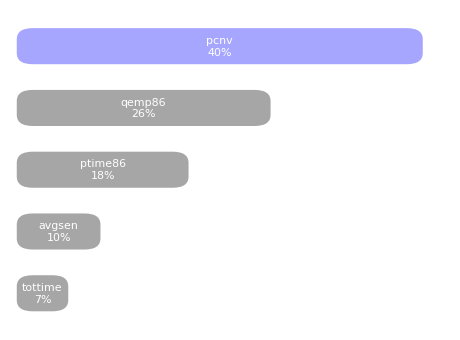

In [26]:
plot_importances(GBC, features);

In [30]:
print_metrics(y_test, X_test, GBC)

The accuracy 0.7287
AUC value is 0.5972

Probability Conditioned on Predicts
> P(not committed a crime|low risk)   74.84%
> P(not committed a crime|high risk)  50.00%
> P(committed a crime|low risk)       25.16%
> P(committed a crime|high risk)      50.00%

Probability Conditioned on Outcomes
> P(low risk|not committed a crime)   94.57%
> P(high risk|not committed a crime)  5.43%
> P(low risk|committed a crime)       85.41%
> P(high risk|committed a crime)      14.59%

Confusion Matrix
> [[470  27]
 [158  27]]
> Columns: predict [0, 1]
> Rows: outcomes [0, 1]



In [31]:
model_xgb = xgboost.XGBClassifier(n_estimators=1000, max_depth=10, use_label_encoder=False, objective='binary:logistic')
model_xgb.fit(X_train, y_train)

c:\Users\LENOVO\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[09:28:29] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [32]:
metrics.roc_auc_score(y_train, model_xgb.predict(X_train))

0.6010219030264051

In [33]:
metrics.roc_auc_score(y_test, model_xgb.predict(X_test))

c:\Users\LENOVO\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


0.5427918864538583

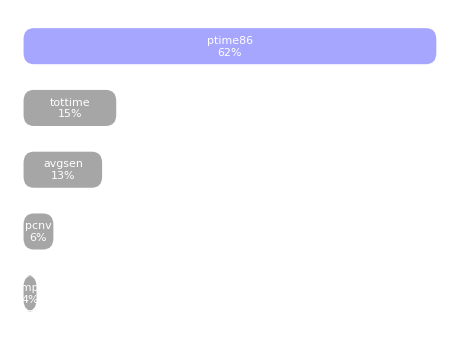

In [34]:
plot_importances(model_xgb, features); plt.show()

In [36]:
print_metrics(y_test, X_test, model_xgb)

The accuracy 0.7243
AUC value is 0.6055

Probability Conditioned on Predicts
> P(not committed a crime|low risk)   74.72%
> P(not committed a crime|high risk)  52.63%
> P(committed a crime|low risk)       25.28%
> P(committed a crime|high risk)      47.37%

Probability Conditioned on Outcomes
> P(low risk|not committed a crime)   93.96%
> P(high risk|not committed a crime)  6.04%
> P(low risk|committed a crime)       85.41%
> P(high risk|committed a crime)      14.59%

Confusion Matrix
> [[467  30]
 [158  27]]
> Columns: predict [0, 1]
> Rows: outcomes [0, 1]



c:\Users\LENOVO\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
c:\Users\LENOVO\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
c:\Users\LENOVO\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
c:\Users\LENOVO\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a fu

# Random Forest

Random forests (Breiman, 2001) is a substantial modification of bagging that builds a large collection of *de-correlated trees*, and then averages them.
On many problems the performance of random forests is very similar to boosting, and they are simpler to train and tune.

* The essential idea in bagging is to average many noisy but approximately unbiased models. The average reduce the variance. 

* Trees are ideal candidates for bagging, since they can capture complex interaction structures in the data, and if grown sufficiently deep, have relatively low bias. 

* Moreover, since each tree generated in bagging is identically distributed $(i.d.)$, the expectation of an average of $B$ such trees is the same as the expectation of any one of them. $E[\bar{X}] = E[X] = \mu $

* This means the bias of bagged trees is the same as that of the individual (bootstrap) trees, and the only hope of improvement is through variance reduction. 

* An average of $B$ i.i.d. rvs, each with variance $σ^2$, has variance $\frac{1}{B}σ^2$. 

* If the variables are simply i.d. (identically distributed, but not necessarily independent) with positive pairwise correlation $ρ$, the variance
of the average is 

$$ρ\sigma^2 + \frac{(1 - ρ)}{B}\sigma^2$$

* Supposing all $\text{Var}$ and pairwise $\text{Cov}$ is the same for all rvs i.d.

* As $B$ increases, the second term disappears, but the first remains, and hence the size of the correlation of pairs of bagged trees limits the benefits
of averaging

* Random forests improve the variance reduction of bagging when reducing the correlation between the trees, without increasing the variance too much. 

* This is **achieved** in the tree-growing process **through random selection of the input variables**.

* Specifically, when growing a tree on a `bootstrapped dataset`:

<center>


**Before each split, select m ≤ p of the input variables at random as candidates for splitting.**


</center>

* Typically values for $m$ are $\sqrt{p}$ or even as low as $1$.
* Recall, regression and classification trees partition the space of all joint predictor variable values into disjoint regions $R_j, j = 1, 2, . . . , J$, as represented by the terminal nodes of the tree.

* A constant $γ_j$ is assigned to each such region and the predictive rule is

$$x ∈ R_j ⇒ f(x) = γ_j$$

* Thus a tree can be formally expressed as

$$ T(x; Θ) = \sum_{j=1}^{J} γ_j I(x ∈ R_j) $$ 

* with parameters $Θ = \{R_j, γ_j\}^J$ . $J$ is usually treated as a meta-parameter.
* After B such trees $B$ are grown,  the random forest (regression) predictor is:

$$\hat{f}_{\text{rf}}^{B}(x) = \frac{1}{B} \sum_{b = 1}^{B} T(x; Θ)$$

* $Θ_b$ characterizes the bth random forest tree in terms of split variables, cutpoints at each node, and terminal-node values.

* Intuitively, reducing $m$ will reduce the correlation between any pair of trees in the ensemble, and hence reduce the variance of the average.

* In generally, gradient boosting is better than random forest

* `Out the bag` sample is the dataset that were not used to fit the $B$ models, almost alway is 1/3 of the original data.

* This data are used to evaluate the predictions of random forest model $\hat{f}_{\text{rf}}^{B}(x)$.

* It pass this dataset on the fitten model by bostraping dataset and compute **Out of the Bag error** `OOBE`

* Then, refit the models using differents $\text{m} + 1$  columns (features) instead $\text{m}$ and compare the `OOBE` of the models 

* The process is iterative, and the best model is choosen



In [37]:
from sklearn.ensemble import RandomForestClassifier # RandomForestRegressor
import pandas as pd
import numpy as np
from sklearn import model_selection, metrics

In [38]:
# Load the data
data_crimen = pd.read_stata(r'data_dta/CRIME1.dta')

# Generate the variable arr86, where a person is labeled equal to 0, if he has not committed a crime in 1986
# otherwise 1.
data_crimen['arr86'] = data_crimen.narr86.where(data_crimen.narr86==0, 1)

# Selecting the features and target
features= ['pcnv', 'avgsen', 'tottime', 'ptime86', 'qemp86']
target = 'arr86'

X, y = data_crimen[features], data_crimen[target]
# split data
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=123, test_size=0.25)

In [39]:
rf = RandomForestClassifier(n_estimators=1000, oob_score=True, verbose=True, min_samples_split=10)
rf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    1.8s finished


RandomForestClassifier(min_samples_split=10, n_estimators=1000, oob_score=True,
                       verbose=True)

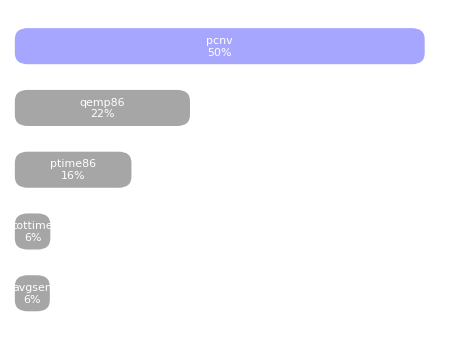

In [40]:
plot_importances(rf, features); plt.show()

In [41]:
metrics.roc_auc_score(y_test, rf.predict(X_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished


0.545494589156561

In [42]:
rf.oob_score_

0.7219774840920216

In [43]:
rf.oob_decision_function_

array([[0.94223685, 0.05776315],
       [0.76037411, 0.23962589],
       [0.91341568, 0.08658432],
       ...,
       [0.74978419, 0.25021581],
       [0.67664907, 0.32335093],
       [0.69326051, 0.30673949]])

In [44]:
rf.score(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished


0.7650513950073421

In [45]:
rf.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished


0.7258064516129032

# References

  1. Trevor Hastie, Robert Tibshirani, Jerome Friedman - The Elements of Statistical Learning Data Mining, Inference, and Prediction

  2. Robert V. Hogg -  Introduction to Mathematical Statistics

  3. [StatQuest with Josh Starmer -> YouTube](https://www.youtube.com/watch?v=sQ870aTKqiM)

  4. [AdaBoost, Clearly Explained](https://www.youtube.com/watch?v=LsK-xG1cLYA)
